# Modelagem Baseline - AMST - Predição de Color EBC

## Contexto e Objetivo

Após a etapa de análise exploratória, em que foram investigadas a distribuição do target, as relações entre variáveis e as principais características do processo produtivo, inicia-se a fase de modelagem preditiva.

O objetivo deste notebook é estabelecer modelos de referência (*baselines*) para a predição da cor (EBC) do mosto frio do produto AMST. Esses modelos servem como ponto de partida para avaliar o ganho real de performance obtido por abordagens mais complexas e para validar hipóteses levantadas durante o EDA.

Nesta etapa, são avaliados modelos simples e interpretáveis, incluindo:
- um baseline ingênuo (Dummy Regressor), utilizado como limite mínimo de desempenho;
- um modelo linear regularizado (Ridge Regression), para verificar se relações lineares são suficientes para explicar o comportamento do target;
- um modelo não linear baseado em árvores (Random Forest com hiperparâmetros default), para avaliar o impacto inicial da captura de interações entre variáveis.

Todas as avaliações são realizadas utilizando uma estratégia de divisão temporal dos dados, respeitando a ordem cronológica dos lotes e evitando vazamento de informação entre treino e teste. As métricas de desempenho adotadas refletem tanto a precisão média quanto a penalização de erros mais elevados, alinhadas ao impacto operacional do problema.

Os resultados obtidos neste notebook fornecem a base necessária para decidir se modelos mais complexos e técnicas de otimização são justificadas, direcionando a próxima etapa de modelagem avançada.

## 1. Imports e Carregamento dos Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path("/content/drive/MyDrive/heineken_case").resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(f"Não achei a pasta src em: {PROJECT_ROOT}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "Heineken - Data Science Use Case 3.csv"

In [ ]:
from src.config import RANDOM_STATE, TEST_SIZE, TARGET_COL

from src.data.load_data import load_amst_clean
from src.models.training import train_baseline, train_ridge_default
from src.models.tuning import tune_random_forest
from src.features.preprocessing import add_domain_features, build_preprocess_pipeline, temporal_train_test_split
from src.models.pipelines import build_dummy_pipeline, build_ridge_pipeline, build_rf_pipeline
from src.models.evaluation import eval_regression

## 2. Carregar e preparar os dados (limpeza + features)

In [ ]:
# Carregando os dados brutos
df = pd.read_csv(DATA_PATH)
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M", errors="coerce")

# Foco no produto AMST (escopo do case)
df_amst = df[df["Product"] == "AMST"].copy()
print("Dimensão AMST (bruto):", df_amst.shape)

# Regras de limpeza:
# - remover linhas sem target
# - remover Color < 0 (fisicamente impossível)
df_amst = df_amst[df_amst["Color"].notna()]
df_amst = df_amst[df_amst["Color"] >= 0]

# Ordenar temporalmente (importante para split de série temporal)
df_amst = df_amst.sort_values("Date/Time")

print("Dimensão AMST após limpeza:", df_amst.shape)

Dimensão AMST (bruto): (460, 22)
Dimensão AMST após limpeza: (427, 22)


In [ ]:
# Feature engineering
df_amst["total_malt"] = (
    df_amst["Roast amount (kg)"]
    + df_amst["1st malt amount (kg)"]
    + df_amst["2nd malt amount (kg)"]
)

df_amst["roast_pct"] = np.where(
    df_amst["total_malt"] > 0,
    df_amst["Roast amount (kg)"] / df_amst["total_malt"],
    0.0
)

df_amst["mt_energy"] = df_amst["MT - Temperature"] * df_amst["MT - Time"]
df_amst["wk_energy"] = df_amst["WK - Temperature"] * df_amst["WK - Time"]

# Definir colunas a descartar como features
drop_cols = ["Unnamed: 0", "Product", "Job ID", "Date/Time"]

feature_cols = [
    c for c in df_amst.columns
    if c not in drop_cols + ["Color"]
]

print("Total de features:", len(feature_cols))
feature_cols

Total de features: 21


['Roast amount (kg)',
 '1st malt amount (kg)',
 '2nd malt amount (kg)',
 'MT - Temperature',
 'MT - Time',
 'WK - Temperature',
 'WK - Steam',
 'WK - Time',
 'Total cold wort',
 'pH',
 'Extract',
 'WOC - Time',
 'WHP Transfer - Time',
 'WHP Rest - Time',
 'Roast color',
 '1st malt color',
 '2nd malt color',
 'total_malt',
 'roast_pct',
 'mt_energy',
 'wk_energy']

## 3. Split temporal treino / teste

In [ ]:
n_rows = df_amst.shape[0]
split_idx = int(n_rows * (1 - TEST_SIZE))

train = df_amst.iloc[:split_idx]
test  = df_amst.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["Color"]

X_test  = test[feature_cols]
y_test  = test["Color"]

print("Total linhas:", n_rows)
print("Treino:", X_train.shape[0], "| Teste:", X_test.shape[0])
print("Período treino: ", train["Date/Time"].min(), "→", train["Date/Time"].max())
print("Período teste : ", test["Date/Time"].min(),  "→", test["Date/Time"].max())

Total linhas: 427
Treino: 341 | Teste: 86
Período treino:  2020-10-22 02:50:00 → 2020-11-27 23:01:00
Período teste :  2020-11-27 23:16:00 → 2020-11-30 03:16:00


## 4. Pipeline de pré-processamento

In [ ]:
preprocess = build_preprocess_pipeline(feature_cols)
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Roast amount (kg)', '1st malt amount (kg)',
                                  '2nd malt amount (kg)', 'MT - Temperature',
                                  'MT - Time', 'WK - Temperature', 'WK - Steam',
                                  'WK - Time', 'Total cold wort', 'pH',
                                  'Extract', 'WOC - Time',
                                  'WHP Transfer - Time', 'WHP Rest - Time',
                                  'Roast color', '1st malt color',
                                  '2nd malt color', 'total_malt', 'roast_pct',
                                  'mt_energy', 'wk_energy'])])

## 5. Treinar todos os modelos

### 5.1 Baseline (Dummy)

In [ ]:
baseline_result = train_baseline(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    preprocess=preprocess
)

baseline_model = baseline_result["model"]
baseline_metrics = baseline_result["metrics"]


Dummy (mean)              -> MAE:  7.089 | RMSE:  8.835 | R²: -0.009


### 5.2 Ridge (baseline linear)

In [ ]:
ridge_model = train_ridge_default(
    X_train=X_train,
    y_train=y_train,
    preprocess=preprocess
)

y_pred_ridge = ridge_model.predict(X_test)
ridge_metrics = eval_regression(y_test, y_pred_ridge, label="Ridge")

Ridge                     -> MAE: 10.270 | RMSE: 17.804 | R²: -3.097


### 5.3 Random Forest (tuning com RandomizedSearchCV)

In [ ]:
rf_model = build_rf_pipeline(
    preprocess=preprocess,
    random_state=RANDOM_STATE
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_metrics = eval_regression(
    y_test,
    y_pred_rf,
    label="RandomForest (default)"
)

RandomForest (default)    -> MAE:  6.628 | RMSE:  8.314 | R²:  0.106


## 6. Tabela comparativa de resultados

In [ ]:
results = {}

results["dummy"]      = baseline_result["metrics"]
results["ridge"]      = ridge_metrics
results["rf_tuned"]   = rf_metrics

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("rmse")
results_df

,mae,rmse,r2
rf_tuned,6.627898,8.314185,0.106487
dummy,7.088517,8.834768,-0.008908
ridge,10.269627,17.803981,-3.097280


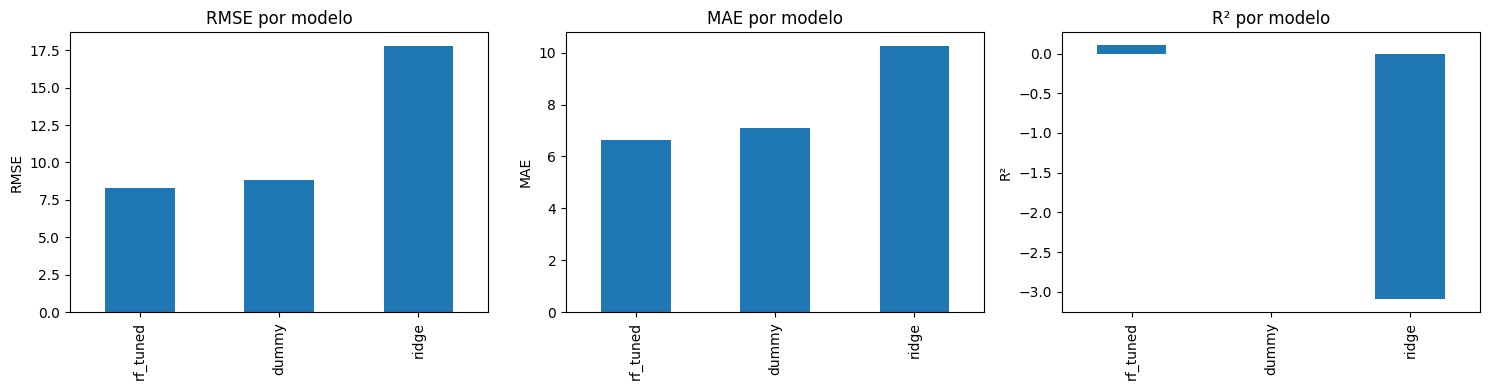

In [ ]:
# Gráfico comparando RMSE, MAE, R²
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

results_df["rmse"].plot(kind="bar", ax=axes[0], title="RMSE por modelo")
axes[0].set_ylabel("RMSE")

results_df["mae"].plot(kind="bar", ax=axes[1], title="MAE por modelo")
axes[1].set_ylabel("MAE")

results_df["r2"].plot(kind="bar", ax=axes[2], title="R² por modelo")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()


## 7. Resumo da Modelagem e Avaliação

Neste notebook, foram avaliados modelos de referência com o objetivo de estabelecer limites claros de desempenho e criar uma base sólida para comparação com abordagens mais avançadas.

O Dummy Regressor foi utilizado como baseline mínimo, fornecendo uma referência ingênua baseada na média do target. Em seguida, um modelo linear regularizado (Ridge Regression) foi treinado para avaliar a capacidade de modelos lineares em capturar a relação entre variáveis de processo e a cor do mosto.

Os resultados indicaram que, embora o Ridge apresente melhoria em relação ao baseline ingênuo, seu desempenho permanece limitado, evidenciando que relações lineares não são suficientes para explicar a variabilidade da cor (EBC). Esse comportamento está alinhado com os achados da análise exploratória, que indicaram baixa correlação linear e forte dependência de interações entre variáveis.

Na sequência, um modelo não linear baseado em árvores (Random Forest com hiperparâmetros default) foi avaliado. Esse modelo apresentou um ganho significativo de desempenho em relação aos modelos anteriores, reforçando a hipótese de que a predição da cor do mosto depende de relações não lineares e de interações complexas entre composição de maltes e parâmetros térmicos do processo.

Apesar do bom desempenho inicial, o Random Forest avaliado ainda utiliza hiperparâmetros padrão e não explora todo o potencial do algoritmo. Além disso, não foram comparados modelos baseados em boosting, que frequentemente apresentam melhor capacidade de generalização em problemas tabulares.

Dessa forma, os resultados deste notebook indicam a necessidade de avançar para uma etapa de modelagem mais robusta, com foco em otimização de hiperparâmetros e comparação com modelos de maior complexidade. Esses aspectos são abordados no próximo notebook, dedicado à modelagem avançada e à seleção do melhor modelo global.
